## Value at Risk (VaR)
`Value at risk (VaR)` is a single, summary, statistical measure of possible portfolio losses. It aggregates all of the risks in a portfolio into a single number. VaR is defined as the loss level that will not be exceeded with a certain confidence level over a certain period of time. Again, this is related to the idea of downside risk, which
measures the likelihood that a financial instrument or portfolio will lose value.

`Definition:` $\text{VaR}_{H,\alpha}$ with time horizon H and confidence level $\alpha$ is defined as that number such that $$\mathbb{P}[L_H < VaR_{H,\alpha}] = \alpha$$
Here $L_H$ is the loss on our portfolio ($L_H = \text{Portfolio}_0 - \text{Portfolio}_H$). The loss at time H is smaller than $VaR_{H,\alpha}$ with $\mathbb{P}$-probalility $\alpha$.In other word, it is that level of loss over a time T that we will not exceed with $\mathbb{P}$-probalility $\alpha$. VaR is the $\alpha$ $\mathbb{P}$-percentile of the loss distribution over T.

`Drawbacks of VaR: `
* VaR does not take into account the tail structure beyond the percentile.
* VaR is not sub-additive on portfolios. Suppose we have two portfolios P1 and P2, and a third portfolio P = P1 + P2 that is given by the two earlier portfolios together. VaR at a given confidence level and horizon would be sub-additive if $VaR(P1 + P2) \leq VaR(P1) + VaR(P2)$. i.e. the risk of the total portfolio is smaller than the sum of the risks of its sub-portfolios (benefits of diversification). However, this is not true for VaR.

## Expected Shortfall (ES)/Conditional Value at Risk (CVaR)
As a remedy to this sub-additivity problem and only partly to the first drawback(tail Structure), a new risk measure Expected Shortfall (ES) or Conditional VaR (CVaR) has been introduced. ES requires us to compute VaR first, and then takes the expected value on the Tail of the loss distribution for values larger than VaR conditional on the loss being larger than Value at Risk. ES is sub-additive. ES looks at the tail after VaR, but only in expectation, without analyzing the tail structure carefully. Hence, it is only a partial solution to tail structure problem.

`Definition: ` ES/CVaR for a portfolio at a confidence level $\alpha$ and a risk horizon H is
$$\text{CVaR}_{H,\alpha} = \mathbb{E}^{\mathbb{P}} [\text{L}_{\text{H}}|\text{L}_\text{H} > \text{VaR}_{H,\alpha} ] $$
Other names this is average value at risk (AVaR) and expected tail loss (ETL).

`Examples:`
- If $\text{VaR}_{(95\%)} = 3.5\%$, Then there is a $5\%$ chance to lose $3.5\%$ or more in a given day.
- If $\text{CVaR}_{(95\%)} = 4.5\%$, Then in the worst $5\%$ of returns your average loss will be $4.5\%$.
- Let `No. of days = 2000, confidence level = 0.999 and stepsize = 1day`. So its 1 day out of 1000 days. In this case 1day in 5years event. If $\text{Normal VaR} = 17\%$down and $\text{Extreme Value Theory VaR} = 41.5\%$down then in 1day out of 5years we could expect losses beyond 41.5%.

<u>Calculation Methods for VaR and CVaR</u>:
- Historical Method: Makes no assumptions about Asset distribution.
- Parametric Method (Variance-Covariance): Must use specific distribution for all assets.
- Monte Carlo Method: Can use any distribution for each assets.

### Historical VaR and CVaR

In [1]:
# Historical VaR and CVaR. 
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import mathfinance as mf
plt.rcParams['figure.figsize'] = [15,7]

In [2]:
# Initialising Stock information to extract returns data.
ticker = ['BCS', 'HSBC', 'BAC', 'C', 'UBS', 'NWG', 'JPM', 'GS']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

# Importing Data.
returns, meanReturns, covMatrix = mf.read_return_history(ticker, start=startDate, end=endDate, interval = '1d')
print(returns.shape)
print(meanReturns.shape, covMatrix.shape)

# Allocating random weights to our portfolio.
n = returns.shape[1]  # Same size as number of stocks in our portfolio.
weights = np.random.rand(n)
s = np.sum(weights)
weights = weights/s  # Normalising so that all the weights adds up to 1.

(550, 8)
(8,) (8, 8)


### Historical VaR and CVaR.
If $X$ is a Random variable for P&L then $Y:= -X$ is the Loss distribution. $F_{x}(x)$ is the CDF of P&L distribution and $F_{Y}^{-1}(y)$ is the inverse CDF of Loss distribution.
$$\text{VaR}_{\alpha} (X) = -{\cal inf} \{x\in \mathbb{R} | F_{x}(x) > \alpha\} = F_{Y}^{-1}(1-\alpha)$$
Note, we make no assumptions about the distribution of returns.
$$\text{CVaR}_{\alpha} (X) = \mathbb{E}[-X | -X > VaR_{\alpha} (X)]$$

In [3]:
def historic_var(returns, weights, confidence_level=0.95):
    '''
    This function takes in a numpy array of stock returns where each column represents returns for a different
    stock. It then calculates the portfolio returns and computes the VaR based on the specified confidence 
    level (default is 95%). It also calculates VaR for individual stock.  
    
            Parameters:
                    returns (double) : 2D-Numpy array of Stock Price returns.
                    weights (double) : 1D-Numpy array of weights of our portfolio.
                    confidence_level(double) : Confidence level of VaR (default is 95%).
                 
            Returns:
                    portfolio_var (double): VaR of the portfolio at the confidence level.
                    individual_vars (np.array): Numpy array containing VaR for each stock.
    '''
    portfolio_returns = returns @ weights    
    portfolio_var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    individual_vars = np.percentile(returns, (1 - confidence_level) * 100, axis=0)
    return portfolio_var, individual_vars

def historic_cvar(returns, weights, confidence_level=0.95):
    '''
    Also known as Expected Shortfall, is the expected loss given that the loss exceeds the VaR. It computes the 
    portfolio returns, calculates the portfolio VaR at the specified confidence level, and then computes the CVaR by taking
    the mean of the returns that fall below the VaR. It also calculates CVaR for individual stock. 
    
            Parameters:
                    returns (double) : 2D-Numpy array of Stock Price returns.
                    weights (double) : 1D-Numpy array of weights of our portfolio.
                    confidence_level(double) : Confidence level of CVaR.
                 
            Returns:
                    portfolio_cvar (double): CVaR of the portfolio at the confidence level. 
                    individual_cvars (np.array): Numpy array containing CVaR for each stock.
    '''
    portfolio_returns = returns @ weights
    portfolio_var,individual_vars = historic_var(returns, weights, confidence_level = confidence_level)
    
    portfolio_cvar = np.mean(portfolio_returns[portfolio_returns <= portfolio_var])
    individual_cvars = np.mean(returns[returns <= individual_vars.reshape(1, -1)], axis=0)
    return portfolio_cvar, individual_cvars

In [4]:
Time  = 10 # 10 day time horizon.

# Calculating Historical VaR.
var_95 = historic_var(returns, weights, confidence_level=0.95)[0]*np.sqrt(Time)
var_99 = historic_var(returns, weights, confidence_level=0.99)[0]*np.sqrt(Time)
var_999 = historic_var(returns, weights, confidence_level=0.999)[0]*np.sqrt(Time)
print(f'VaR(95%) = {var_95*100:.2f}%  VaR(99%) = {var_99*100:.2f}%  VaR(99.9%) = {var_999*100:.2f}%')

VaR(95%) = -8.05%  VaR(99%) = -12.38%  VaR(99.9%) = -16.04%


In [5]:
# Calculating Historical CVaR/Expected Shortfall.
cvar_95 = historic_cvar(returns, weights, confidence_level=0.95)[0]*np.sqrt(Time)
cvar_99 = historic_cvar(returns, weights, confidence_level=0.99)[0]*np.sqrt(Time)
cvar_999 = historic_cvar(returns, weights, confidence_level=0.999)[0]*np.sqrt(Time)
print(f'CVaR(95%) = {cvar_95*100:.2f}%  CVaR(99%) = {cvar_99*100:.2f}%  CVaR(99.9%) = {cvar_999*100:.2f}%')

CVaR(95%) = -10.70%  CVaR(99%) = -14.23%  CVaR(99.9%) = -17.31%


In [6]:
# Calculating risk metric(historical) for investment.
var_95 = -historic_var(returns, weights, confidence_level=0.95)[0]*np.sqrt(Time)
cvar_95 = -historic_cvar(returns, weights, confidence_level=0.95)[0]*np.sqrt(Time)
portfolioReturn, portfolioStd, sharpeRatio = mf.portfolioMetric(weights, meanReturns, covMatrix, Time, riskfreerate = 0.05)

investment = 1000000    # Initial investment of £1 million in the portfolio of stocks.
print(f'Expected Portfolio Return :                      £{investment*portfolioReturn:.2f}')
print(f'Value at Risk(VaR) at 95% confidence level :     £{investment*var_95:.2f}')
print(f'Conditional VaR at 95% confidence level :        £{investment*cvar_95:.2f}')
print(f'At a {Time} day time horizon, we expect to make £{investment*portfolioReturn:.2f}. But at 95% confidence interval we are not going to lose more than £{investment*var_95:.2f}.\
 In the worst 5th percentile, the Expected lose in our portfolio is £{investment*cvar_95:.2f}.')

Expected Portfolio Return :                      £212.65
Value at Risk(VaR) at 95% confidence level :     £80513.83
Conditional VaR at 95% confidence level :        £106963.43
At a 10 day time horizon, we expect to make £212.65. But at 95% confidence interval we are not going to lose more than £80513.83. In the worst 5th percentile, the Expected lose in our portfolio is £106963.43.


### Parametric Method (Variance-Covariance) VaR and CVar

Under the assumption of normality, for a confidence level $\alpha$, the formula for parametric VaR can be calculated as:
$$ \text{VaR}_{\alpha} (X) = \mu_{portfolio} - \sigma_{portfolio} * \text{zscore}$$
The formula for CVaR of the portfolio at the confidence level $\alpha$ is:
$$\text{CVaR}_\alpha(X) = \sigma_{portfolio}\frac{\varphi(\Phi^{-1}(\alpha))}{\alpha} -\mu_{portfolio}$$

In [85]:
def parametric_var(portfolioReturn, portfolioStd, confidence_level=0.95):
    '''
    This function uses the mean and standard deviation of the portfolio returns to estimate the VaR based on 
    the normal distribution assumption. 
    
            Parameters:
                    portfolioReturn (double) : Mean returns of a portfolio.
                    portfolioStd (double) : Standard deviation of portfolio.
                    confidence_level (float) : Confidence level for VaR calculation (default is 0.95).

            Returns:
                    var (double) : Value at Risk at the specified confidence level.
    '''
    var = portfolioReturn - portfolioStd * norm.ppf(0.95)
    return -var

def parametric_cvar(portfolioReturn, portfolioStd, confidence_level=0.95):
    '''
    This function uses the mean and standard deviation of the portfolio returns to estimate the CVaR based on 
    the normal distribution assumption. 
    
            Parameters:
                    portfolioReturn (double) : Mean returns of a portfolio.
                    portfolioStd (double) : Standard deviation of portfolio.
                    confidence_level (float) : Confidence level for VaR calculation (default is 0.95).

            Returns:
                    cvar (double) : CVaR of the portfolio at the confidence level. 
    '''
    cvar = portfolioStd * (1-confidence_level)**-1 * norm.pdf(norm.ppf(1-confidence_level)) - portfolioReturn
    return cvar

In [86]:
pvar_95 = parametric_var(portfolioReturn, portfolioStd, confidence_level=0.95)
pcvar_95 = parametric_cvar(portfolioReturn, portfolioStd, confidence_level=0.95)
print(f'Parametric Value at Risk(VaR) under Normality assumption at 95% confidence level :     £{investment*pvar_95:.2f}')
print(f'Parametric Conditional VaR under Normality assumption at 95% confidence level :        £{investment*pcvar_95:.2f}')

Parametric Value at Risk(VaR) under Normality assumption at 95% confidence level :     £79349.50
Parametric Conditional VaR under Normality assumption at 95% confidence level :        £100132.10


### Adapt the parametric method for fat tail distribution
if the dataset is large and still exhibits heavy tails or outliers, the Student's t-distribution might not be the best fit. In such cases, you might consider more robust methods or distributions that handle heavy tails better, such as the Generalized Pareto Distribution (GPD) or Extreme Value Theory (EVT).

For instance, you could use the Peak Over Threshold (POT) method with EVT to estimate extreme quantiles like VaR and CVaR. This method involves fitting a Generalized Pareto Distribution to the tail of the data that exceeds a certain threshold.

Here's a basic example using the scipy.stats module for EVT:

In [61]:
from scipy.stats import genpareto

def parametric_var_evt(returns, threshold=0, confidence_level=0.95):
    portfolio_returns = np.sum(returns, axis=1)
    excess_returns = portfolio_returns[portfolio_returns > threshold] - threshold
    params = genpareto.fit(excess_returns)
    var = genpareto.ppf(1 - confidence_level, *params) + threshold
    return var

def parametric_cvar_evt(returns, threshold=0, confidence_level=0.95):
    portfolio_returns = np.sum(returns, axis=1)
    excess_returns = portfolio_returns[portfolio_returns > threshold] - threshold
    params = genpareto.fit(excess_returns)
    var = genpareto.ppf(1 - confidence_level, *params) + threshold
    cvar = (genpareto.expect(lambda x: x, args=params, loc=threshold) - threshold) / (1 - confidence_level)
    return cvar

In this example, the genpareto.fit function fits the Generalized Pareto Distribution to the excess returns (returns above the specified threshold). Then, the quantiles for VaR and CVaR are estimated using genpareto.ppf, and for CVaR, the genpareto.expect function is used to calculate the expected shortfall.

Remember that choosing an appropriate distribution or method for extreme events heavily depends on the characteristics of your dataset and the underlying assumptions you're willing to make. Evaluating the fit of the selected distribution/model to the data and considering domain knowledge is crucial.

### Monte Carlo Method (VaR & CVaR)

Here, we assume `daily returns` are distributed by a Multivariate Normal Distribution $\mathbf{r_t}\ \sim\ \mathcal{N}(\boldsymbol\mu,\, \boldsymbol\Sigma)$. Since, $L L^T = \Sigma$, We can use 
Cholesky Decomposition to find the Lower triangular matrix $L$. The daily returns can then be written as $$r_{t} = \mu + LZ_{t}$$ where $Z_{t}\sim \mathcal{N}(0,I)$ and $I$ = Identity Matrix.

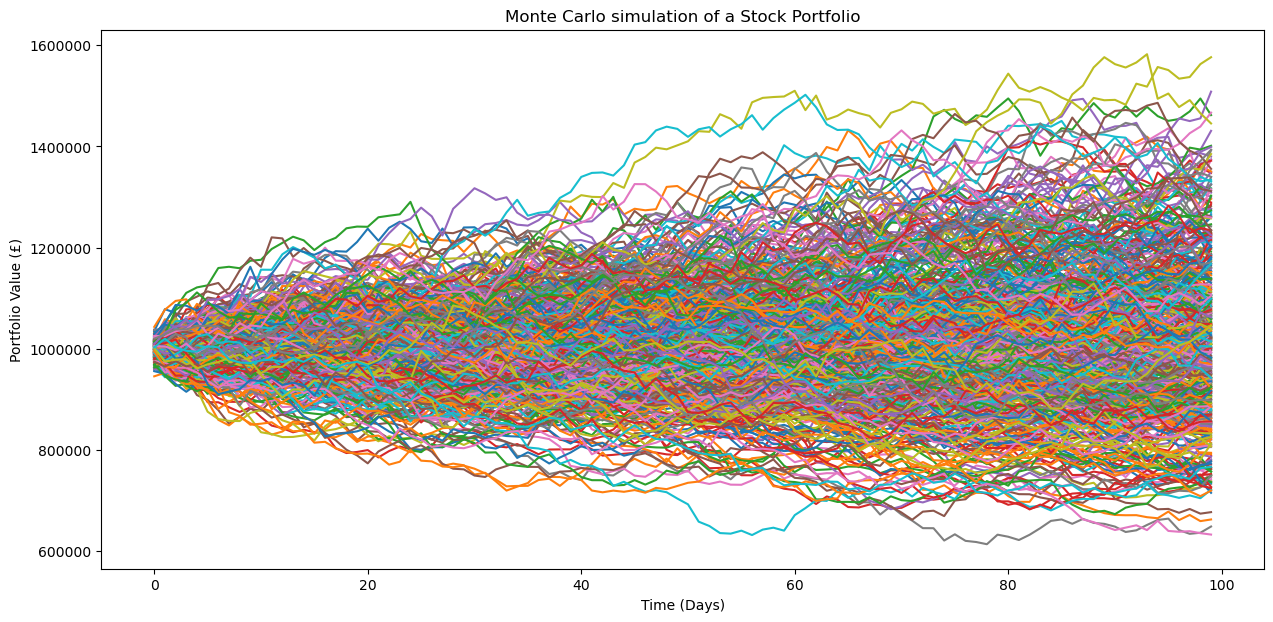

In [88]:
# Initialising.
numberOfSimulations = 500 # Number of simulations in Monte Carlo.
T = 100 # Time in days.
initialPortfolio = 1000000  # Initial investment of £1 million.
meanMatrix = np.full(shape=(T, len(weights)), fill_value=meanReturns)  # Mean Matrix filled with meanReturns of dimension (Time x No of Stocks).
meanMatrix = meanMatrix.T  # Using Transpose to change the dimension to (No of Stocks x Time) for matching the dimension in r = mu + LZ used below.
simulatedPortfolio = np.full(shape=(T, numberOfSimulations), fill_value=0.0)  # Initialising portfolio matrix of size (Time x No of simulations) with all entries zero.
# Performing Monte Carlo simulation.
for i in range(0, numberOfSimulations):
    # Monte Carlo loop.
    Z = np.random.normal(size=(T, len(weights)))  # Each element in this array Z of size (Time x No of Stocks) is a random number generated from a standard normal distribution.
    L = np.linalg.cholesky(covMatrix)  # Lower Triangular matrix of size (No of Stocks x No of Stocks).
    dailyReturns = meanMatrix + L @ Z.T    # Daily returns of size (No of Stocks x Time).
    simulatedPortfolio[:,i] = np.cumprod((dailyReturns.T @ weights)+1)*initialPortfolio  # Simulates portfolio values over time by applying daily returns to the initial investment using a 
                                                                                         # cumulative product operation, thus representing the potential growth or decline of the portfolio value over
                                                                                         # the specified time horizon based on the simulated returns. (+1) to convert the returns to growth factors.

# Plotting graph of Portfolio Value against Time.
plt.plot(simulatedPortfolio)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Portfolio Value (£)') 
plt.xlabel('Time (Days)')
plt.title('Monte Carlo simulation of a Stock Portfolio')
plt.show()

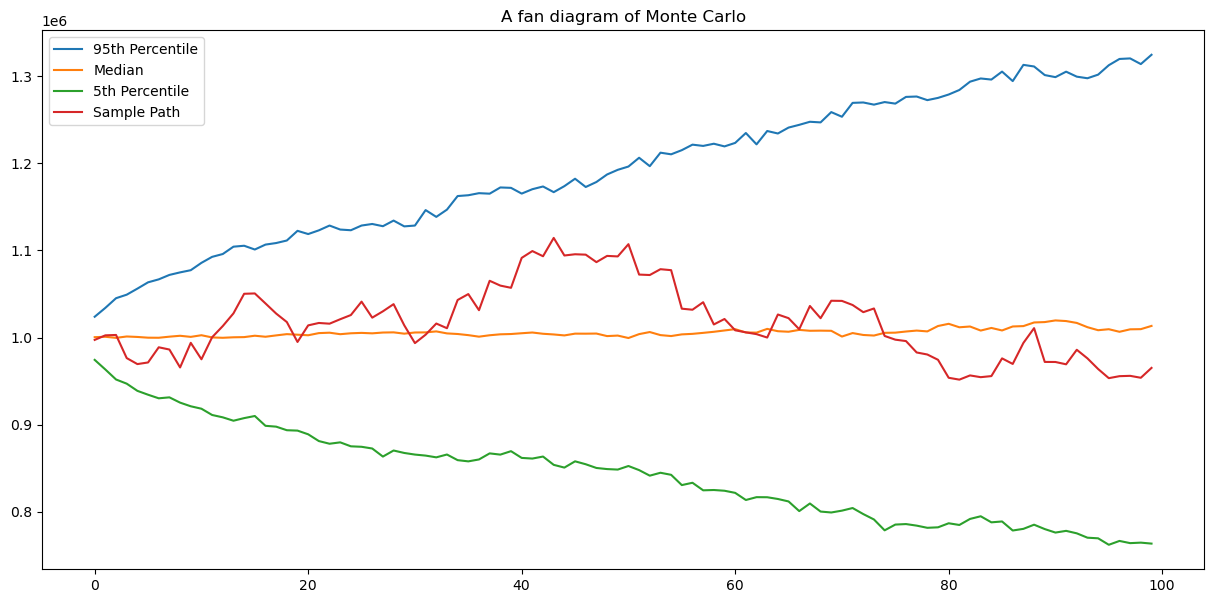

In [89]:
times = np.arange(T)
top_five_percent = np.percentile(simulatedPortfolio,95,1)
bottom_five_percent = np.percentile(simulatedPortfolio,5,1)
median = np.percentile(simulatedPortfolio,50,1)
plt.plot(times, top_five_percent, label='95th Percentile')
plt.plot(times,median, label='Median')
plt.plot(times, bottom_five_percent, label='5th Percentile')
plt.plot(times,simulatedPortfolio[:,2], label='Sample Path');
plt.title('A fan diagram of Monte Carlo')
plt.legend();

In [90]:
def monteCarloVaR(simulatedPortfolio, confidence_level=0.95):
    """  This function takes in a numpy array of stock returns where each column represents returns for a different
    stock. It then calculates the portfolio returns and computes the VaR based on the specified confidence 
    level (default is 95%). It also calculates VaR for individual stock.  
    
            Parameters:
                    returns (double) : 2D-Numpy array of Stock Price returns.
                    weights (double) : 1D-Numpy array of weights of our portfolio.
                    confidence_level(double) : Confidence level of VaR (default is 95%).
                 
            Returns:
                    portfolio_var (double): VaR of the portfolio at the confidence level.
                    individual_vars (np.array): Numpy array containing VaR for each stock.
    """
    var = np.percentile(simulatedPortfolio, (1 - confidence_level) * 100)
    return var

def monteCarloCVaR(simulatedPortfolio, confidence_level=0.95):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    var = monteCarloVaR(simulatedPortfolio, confidence_level = confidence_level)
    cvar = np.mean(simulatedPortfolio[simulatedPortfolio <= var])
    return cvar

In [91]:
portfolioResults = simulatedPortfolio[-1,:]  # All simulation values at the very last time step.

VaR_95 = initialPortfolio - monteCarloVaR(portfolioResults, confidence_level=0.95)
CVaR_95 = initialPortfolio - monteCarloCVaR(portfolioResults, confidence_level=0.95)

print(f'Value at Risk(VaR) at 95% confidence level :     £{VaR_95 :.2f}')
print(f'Conditional VaR at 95% confidence level :        £{CVaR_95:.2f}')

Value at Risk(VaR) at 95% confidence level :     £236456.14
Conditional VaR at 95% confidence level :        £274006.14
